In [1]:
import numpy as np
import subprocess as sub
import SWAT_ReadOut as read
from SWAT_Manipulate import rteManipulator
from SWAT_Manipulate import bsnManipulator
from SWAT_Manipulate import gwManipulator
from SWAT_Manipulate import solManipulator
from SWAT_Manipulate import mgtManipulator
from SWAT_Manipulate import hruManipulator
import os, shutil

from mpi4py import MPI

import spotpy

In [6]:
class spot_setup(object):
    def __init__(self,para):
        self.parameter_fname = 'input_wwr_hp.txt'
        self.observeddata_fname = 'observed'+os.sep+'discharge2.txt'
        self.observeddata = np.loadtxt(self.observeddata_fname)
        self.nr_of_observations = len(self.observeddata)
        self.para = para
        self.parf = np.genfromtxt(self.parameter_fname, delimiter=',', dtype=None, encoding='utf-8')
        self.params = []
        for i in range(len(self.parf)):
            self.params.append(
                spotpy.parameter.Uniform(
                    self.parf[i][0], self.parf[i][1], np.mean( [self.parf[i][1],self.parf[i][2]] )))
    
    
    def parameters(self):
        return spotpy.parameter.generate(self.params)
    
    
    def onerror(self, func, path, exc_info):
        """
        Error handler for ``shutil.rmtree``.
    
        If the error is due to an access error (read only file)
        it attempts to add write permission and then retries.
    
        If the error is for another reason it re-raises the error.
    
        Usage : ``shutil.rmtree(path, onerror=onerror)``
        """
        import stat
        if not os.access(path, os.W_OK):
            # Is the error an access error ?
            os.chmod(path, stat.S_IWUSR)
            func(path)
        else:
            raise
    
    
    def evaluation(self):
        # Load Observation data here and return them as lists [[],[],[]...]
        observationdatalists = []
        observationdatalists.append(self.observeddata)        
        return observationdatalists
    
    
    def objectivefunction(self,simulation,evaluation):
        indexs=[]      
        for obs in evaluation:
            index=[]
            for i in range(len(obs)):
                if not obs[i] == -9999: #used for missing observation data
                    index.append(i)                    
            indexs.append(index)
        sub1 = np.array(simulation[0])
        sub = np.array(sub1)[indexs[0]] 
        sub_nse1 = spotpy.objectivefunctions.lognashsutcliffe(evaluation[0][indexs[0]],sub, epsilon=0.001)
        sub_nse = sub_nse1 - 1
        return sub_nse
    
    
    # import datetime as DT 
    # def make_date(datestr):
    #     return DT.datetime.strptime(datestr, '%Y%m%d')
    
    
    def simulation(self,vector):    
        # if self.para == 'mpi':
        try:
            # +1 to prevent zero if necessary...
            core_nr = str(int(os.environ['OMPI_COMM_WORLD_RANK']))
        except KeyError:
            # if you run on windows
            core_nr = str(1)
            #str(int(np.random.uniform(0,1000)))
        pathdir = 'calib_parallel'+ os.sep +'parallel_'+core_nr 
        if os.path.exists(pathdir+ os.sep):
            print('Deleting folder ' + pathdir)
            shutil.rmtree(pathdir, onerror=self.onerror)
            print('Copying folder ' + pathdir)
            shutil.copytree('TxtInOut', pathdir)
        else:
            print('Copying folder ' + pathdir)
            shutil.copytree('TxtInOut', pathdir)
        files=os.listdir(pathdir)
        
        # else:
        #     files=os.listdir('TxtInOut')
        #     files=os.listdir('calib_parallel'+os.sep+'parallel_'+core_nr)

        #     for i in range(len(self.parnames)):
        #         rtefiles = [i for i in files if i.endswith(".rte")]
        #         for d in rte:
        #             if name in d.parInfo:
        #                 d.setChangePar(self.parnames[i],vector[i],self.parroutine[i]w)
        #                     for d in gw:
        #                         if name in d.parInfo:
        #                         d.setChangePar(self.parnames[i],vector[i],self.parroutine[i]w)
            
        manipulators = {}
        
        ### here all parameters from the bsn-file are assigned in the dictionary for calibration
        bsnfiles = [i for i in files if i.endswith(".bsn")]
        bsn = []
        for i in bsnfiles:
            bsn.append(bsnManipulator(i, ["SURLAG","SFTMP","SMTMP","TIMP","ESCO","EPCO"], core_nr))
        manipulators["bsn"] = bsn
        
        ### here all parameters from the gw-file are assigned in the dictionary for calibration
        gwfiles = [i for i in files if i.endswith(".gw")]
        gw = []
        for i in gwfiles:
            gw.append(gwManipulator(i, ["GW_DELAY","ALPHA_BF","GW_REVAP","GWQMN","RCHRG_DP","REVAPMN"], core_nr))
        manipulators["gw"] = gw
       
        ### here all parameters from the sol-file are assigned in the dictionary for calibration
        solfiles = [i for i in files if i.endswith(".sol")]
        sol = []
        for i in solfiles:
            if solManipulator(i,[],core_nr).landuse != "URBN":
                sol.append(solManipulator(i, ["SOL_K","ROCK","SOL_AWC"], core_nr))
        manipulators["sol"] = sol
        
        ## here all parameters from the hru-file are assigned in the dictionary for calibration
        hrufiles= [i for i in files if i.endswith(".hru")]
        hru=[]
        for i in hrufiles:
            if i[0].isdigit():
                hru.append(hruManipulator(i, ["HRU_FR","ESCO","EPCO","OV_N","CANMX"], core_nr))
        manipulators["hru"] = hru
        
        ### here all parameters from the rte-file are assigned in the dictionary for calibration
        rtefiles = [i for i in files if i.endswith(".rte")]
        rte = []
        for i in rtefiles:
            rte.append(rteManipulator(i, ["CH_N2", "CH_K2"], core_nr))
        manipulators["rte"] = rte
        
        ### here all parameters from the mgt-file are assigned in the dictionary for calibration
        mgtfiles = [i for i in files if i.endswith(".mgt")]
        mgt = []
        for i in mgtfiles:
            mgt.append(mgtManipulator(i, ["CN2"], core_nr))
        manipulators["mgt"] = mgt
        
        ### lists with subbasins which should receive different groundwater and routing parameters
        #gw1=["1"]
        #gw2=["10","11"]
        
        ### here the file containing all parameter values is loaded
        data=vector
              
        #### here the iteration starts -> the loop iterates through the total number of parameter combinations
        #data[i,1]
        sftmp = data[0]
        ksat = data[1]
        ch_n2 = data[2]
        delay = data[3]
        CN2 = data[4]
        ESCO = data[5]
        
        ## the parameters in the bsn files are changed
        for d in bsn:
            d.setChangePar("SFTMP",sftmp,"s")
            d.finishChangePar(core_nr)
        
        ##  the parameters in the sol files are changed
        for d in sol:
            d.setChangePar("SOL_K",ksat,"*")
            d.finishChangePar(core_nr)
    
        ## the parameters in the rte files are changed -> the algorithm checks the number of the subbasin and assigns the parameter according
        ## to the list specified above
        for d in rte:
            d.setChangePar("CH_N2",ch_n2,"s")
            d.finishChangePar(core_nr)

        ## the parameters in the gw files are changed -> the algorithm checks the number of the subbasin and assigns the parameter according
        ## to the list specified above
        for d in gw:
            # here different groundwater parameters are applied for different subbasins
            # groundwater region I
            # if d.subbasin in gw1:
            d.setChangePar("GW_DELAY",delay,"s")
            # groundwater region II
            #else:
            d.finishChangePar(core_nr)
             
        ## the parameters in the mgt files are changed
        for d in mgt:
            d.setChangePar("CN2",CN2,"*")
            d.finishChangePar(core_nr)
        
        ## the parameters in the hru files are changed
        for d in hru:
            d.setChangePar("ESCO",ESCO,"s")
            d.finishChangePar(core_nr)
        
        try:
            # os.system("calib_parallel"+os.sep+"parallel_"+core_nr+os.sep+"swat_64rel.exe")
            # swat is finally executed for the current iteration
            # sub.check_call("'calib_parallel'+os.sep+'parallel_'+core_nr+os.sep+'swat_64rel.exe'")
            curdir = os.getcwd()
            os.chdir('calib_parallel'+os.sep+'parallel_'+core_nr)
            sub.call(['swat_64rel.exe'])
            os.chdir(curdir)
            # swat is finally executed for the current iteration
            # sub.check_call("swat_64rel.exe",cwd='calib_parallel'+os.sep+'parallel_'+core_nr+os.sep)
            # subbasin number where output should be extracted
            subbasins = [1]
            # results = (read.rchOutputManipulator(["FLOW_OUT"],subbasins,"indi",False,1,core_nr),
            #            read.subOutputManipulator(["SURQ","GW_Q","LAT_Q","PRECIP"],subbasins,"indi",False,1,core_nr))
            
            results = (read.rchOutputManipulator(["FLOW_OUT"],subbasins,"indi",False,1,core_nr))
            results = []
            for subb in subbasins:
                if subb<10:
                    with open('calib_parallel'+os.sep+'parallel_'+core_nr+os.sep+'SWATsensitivity_FLOW_OUT_000'+str(subb)+'.rch', 'r') as fh:
                        for line in fh:
                            pass
                        last = line
                else:
                    with open('calib_parallel'+os.sep+'parallel_'+core_nr+os.sep+'SWATsensitivity_FLOW_OUT_00'+str(subb)+'.rch', 'r') as fh:
                        for line in fh:
                            pass
                        last = line
                vals = last.split(' ')
                oneresult=[]
                for val in vals:
                    oneresult.append(float(val))
                    
                results.append(oneresult)
        except:
            raise
            print("SWAT produced an error, returning nans")
            # Number of simulations that SWAT creates (without warm-up period)
            results = [[np.nan]*self.nr_of_observations]
        return results
    

In [7]:
parallel = 'mpi' if 'OMPI_COMM_WORLD_SIZE' in os.environ else 'seq'

from mpi4py import MPI

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

display(size)
display(rank)
print(parallel)

# parallel = 'umpc'

# Initiate class
starter = spot_setup(parallel) 

sampler = spotpy.algorithms.lhs(starter, dbname='calib_parallel'+os.sep+'SWAT-discharge_lhs',dbformat='csv', parallel=parallel)
sampler.sample(repetitions=5)


1

0

seq
Initializing the  Latin Hypercube Sampling (LHS)  with  5  repetitions
Starting the LHS algotrithm with 5 repetitions...
Creating LatinHyperCube Matrix
Deleting folder calib_parallel\parallel_1
Copying folder calib_parallel\parallel_1
1 of 5, min objf=-20.808, max objf=-20.808, time remaining: 00:00:48
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'calib_parallel\SWAT-discharge_lhs.csv' created.
Deleting folder calib_parallel\parallel_1
Copying folder calib_parallel\parallel_1
2 of 5, min objf=-20.808, max objf=-20.668, time remaining: 00:00:37
Deleting folder calib_parallel\parallel_1
Copying folder calib_parallel\parallel_1
3 of 5, min objf=-20.808, max objf=-20.668, time remaining: 00:00:20
Deleting folder calib_parallel\parallel_1
Copying folder calib_parallel\parallel_1
4 of 5, min objf=-20.808, max objf=-20.668, time remaining: 00:00:00
Deleting folder calib_parallel\parallel_1
Copying folder calib_parallel\parallel_1
5 of 5, min obj

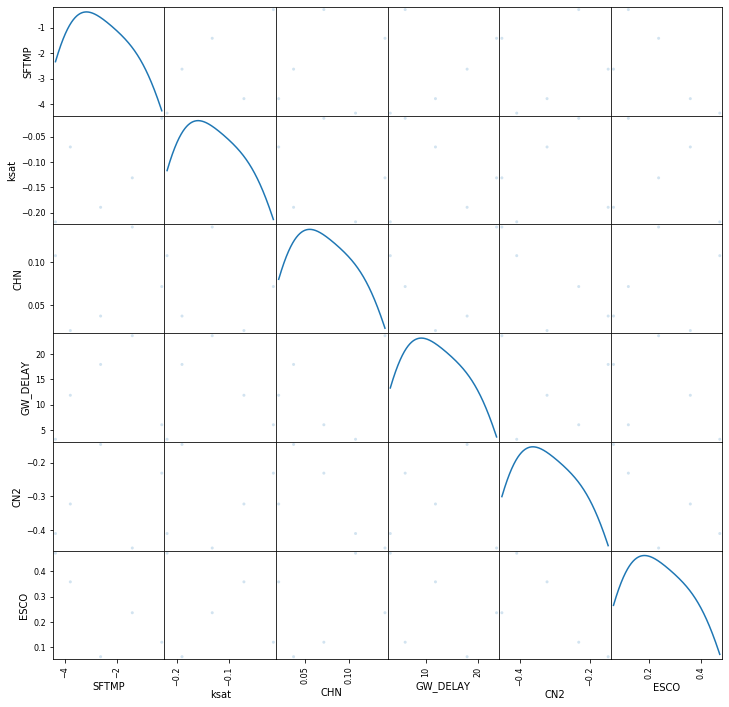

In [10]:
from spotpy import analyser   

results = sampler.getdata()

analyser.plot_parameterInteraction(results) 


In [12]:
# posterior = analyser.get_posterior(results, percentage=10)
# analyser.plot_parameterInteraction(posterior)
analyser.get_best_parameterset(results)


Best parameter set:
SFTMP=-1.414, ksat=-0.1315, CHN=0.1417, GW_DELAY=23.61, CN2=-0.4524, ESCO=0.2367


array([(-1.414, -0.1315, 0.1417, 23.61, -0.4524, 0.2367)],
      dtype={'names':['parSFTMP','parksat','parCHN','parGW_DELAY','parCN2','parESCO'], 'formats':['<f8','<f8','<f8','<f8','<f8','<f8'], 'offsets':[8,16,24,32,40,48], 'itemsize':11752})

In [4]:
spotpy.parameter.Uniform('cmax',low=1.0 , high=500,  optguess=412.33)

Uniform('cmax', [1.0, 500])

In [5]:
parameter_fname = 'input_wwr_hp.txt'
observeddata_fname = 'observed'+os.sep+'discharge2.txt'
observeddata = np.loadtxt(observeddata_fname)
nr_of_observations = len(observeddata)
para = 'seq'
parf = np.genfromtxt(parameter_fname, delimiter=',', dtype=None, encoding='utf-8')

params = []


In [6]:
parf

array([('SFTMP', -5.0e+00,  5.  ), ('ksat', -2.5e-01,  0.25),
       ('CHN',  1.0e-03,  0.3 ), ('GW_DELAY',  0.0e+00, 50.  ),
       ('CN2', -5.0e-01,  0.25), ('ESCO',  0.0e+00,  1.  )],
      dtype=[('f0', '<U8'), ('f1', '<f8'), ('f2', '<f8')])

In [7]:
for i in range(len(parf)):
    print(f"{parf[i][0]}, {parf[i][1]}, np.mean( {parf[i][1]},{parf[i][2]} = {np.mean([parf[i][1],parf[i][2]])})")
    print(spotpy.parameter.Uniform(parf[i][0], parf[i][1], np.mean( [parf[i][1],parf[i][2]] )))
    params.append(spotpy.parameter.Uniform(parf[i][0], parf[i][1], np.mean( [parf[i][1],parf[i][2]] )))

SFTMP, -5.0, np.mean( -5.0,5.0 = 0.0)
Uniform('SFTMP', [-5.0, 0.0])
ksat, -0.25, np.mean( -0.25,0.25 = 0.0)
Uniform('ksat', [-0.25, 0.0])
CHN, 0.001, np.mean( 0.001,0.3 = 0.1505)
Uniform('CHN', [0.001, 0.1505])
GW_DELAY, 0.0, np.mean( 0.0,50.0 = 25.0)
Uniform('GW_DELAY', [0.0, 25.0])
CN2, -0.5, np.mean( -0.5,0.25 = -0.125)
Uniform('CN2', [-0.5, -0.125])
ESCO, 0.0, np.mean( 0.0,1.0 = 0.5)
Uniform('ESCO', [0.0, 0.5])


In [8]:
spotpy.parameter.generate(params)

array([(-3.92052358, 'SFTMP', 0.549 , -2.6   , -5.00e+00, -1.12e-03, False),
       (-0.21819385, 'ksat', 0.0222, -0.127 , -2.50e-01, -6.16e-06, False),
       ( 0.05766887, 'CHN', 0.0131,  0.0757,  1.01e-03,  1.50e-01, False),
       (12.5985647 , 'GW_DELAY', 2.42  , 12.5   ,  4.15e-02,  2.50e+01, False),
       (-0.17684914, 'CN2', 0.0368, -0.311 , -5.00e-01, -1.26e-01, False),
       ( 0.26136814, 'ESCO', 0.0538,  0.249 ,  1.48e-03,  5.00e-01, False)],
      dtype=[('random', '<f8'), ('name', '<U30'), ('step', '<f8'), ('optguess', '<f8'), ('minbound', '<f8'), ('maxbound', '<f8'), ('as_int', '?')])

In [1]:
from mpi4py import MPI

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

display(size)
display(rank)

1

0

In [4]:
import os
'mpi' if 'OMPI_COMM_WORLD_SIZE' in os.environ else 'seq'

'seq'

In [2]:
# only tmp, delete after use
import geopandas as gpd

gdf = gpd.read_file(r'C:\dev\05_geodata\qgis_map_projects\kik_project\grid_tiles\DEM_1m_grid_cells_wzone_overlap_multi.shp', encoding='utf-8')

gdf.sample(5)

,grid_id,filename,zone_id,zoverlap_i,geometry
1,51694,51694_dem_1m.tif,1.0,1.0,"POLYGON ((400000.000 6465000.000, 395000.000 6..."
138,64971,64971_dem_1m.tif,2.0,2.0,"POLYGON ((675000.000 6590000.000, 670000.000 6..."
115,64934,64934_dem_1m.tif,2.0,2.0,"POLYGON ((640000.000 6595000.000, 635000.000 6..."
2481,64224,64224_dem_1m.tif,20.0,20.0,"POLYGON ((630000.000 6525000.000, 625000.000 6..."
1918,64611,64611_dem_1m.tif,16.0,16.0,"POLYGON ((615000.000 6560000.000, 610000.000 6..."


In [6]:
zone_ids = gdf['zone_id'].unique()
zone_ids_o = gdf['zoverlap_i'].unique()
sorted(zone_ids) == sorted(zone_ids_o)

True

In [9]:
display(len(gdf['grid_id'].unique()))
display(len(gdf['zoverlap_i']))

2074

2841

In [13]:
p = r'C:\dev\05_geodata\qgis_map_projects\kik_project\grid_tiles'

for i in sorted(zone_ids):
    fs = gdf[gdf['zoverlap_i'] == i]['filename']
    
    with open(os.path.join(p, f"zone_{int(i)}_dem.csv"), 'w', encoding='utf-8') as fh:
        for elem in fs.unique().tolist():
            fh.write(f"{elem}\n")
            fh.flush()
    

In [37]:
import subprocess

s = r'Z:\Evelyn\est_topographic_metrics\1m\DEM_tiff'

cur_keep = os.path.abspath(os.curdir)

os.chdir(s)

for i in sorted(zone_ids):
    # gdalbuildvrt -input_file_list zone_xxx_dem.csv -a_srs EPSG:3301 zone_xxx_dem.vrt 
    o = subprocess.run(["gdalbuildvrt", "-input_file_list", f"zone_{int(i)}_dem.csv", "-a_srs", "EPSG:3301", "-overwrite", os.path.join(p, f"zone_{int(i)}_dem.vrt")], capture_output=True)
    # o = ["gdalbuildvrt", "-input_file_list", os.path.join(p, f"zone_{int(i)}_dem.csv"), "-a_srs", "EPSG:3301", os.path.join(p, f"zone_{int(i)}_dem.vrt")]
    display(o.stdout)
    display(' '.join(o.args))
    display(o.returncode)

os.chdir(cur_keep)

b'0...10...20...30...40...50...60...70...80...90...100 - done.\r\n'

'gdalbuildvrt -input_file_list zone_1_dem.csv -a_srs EPSG:3301 -overwrite C:\\dev\\05_geodata\\qgis_map_projects\\kik_project\\grid_tiles\\zone_1_dem.vrt'

0

b'0...10...20...30...40...50...60...70...80...90...100 - done.\r\n'

'gdalbuildvrt -input_file_list zone_2_dem.csv -a_srs EPSG:3301 -overwrite C:\\dev\\05_geodata\\qgis_map_projects\\kik_project\\grid_tiles\\zone_2_dem.vrt'

0

b'0...10...20...30...40...50...60...70...80...90...100 - done.\r\n'

'gdalbuildvrt -input_file_list zone_3_dem.csv -a_srs EPSG:3301 -overwrite C:\\dev\\05_geodata\\qgis_map_projects\\kik_project\\grid_tiles\\zone_3_dem.vrt'

0

b'0...10...20...30...40...50...60...70...80...90...100 - done.\r\n'

'gdalbuildvrt -input_file_list zone_4_dem.csv -a_srs EPSG:3301 -overwrite C:\\dev\\05_geodata\\qgis_map_projects\\kik_project\\grid_tiles\\zone_4_dem.vrt'

0

b'0...10...20...30...40...50...60...70...80...90...100 - done.\r\n'

'gdalbuildvrt -input_file_list zone_5_dem.csv -a_srs EPSG:3301 -overwrite C:\\dev\\05_geodata\\qgis_map_projects\\kik_project\\grid_tiles\\zone_5_dem.vrt'

0

b'0...10...20...30...40...50...60...70...80...90...100 - done.\r\n'

'gdalbuildvrt -input_file_list zone_6_dem.csv -a_srs EPSG:3301 -overwrite C:\\dev\\05_geodata\\qgis_map_projects\\kik_project\\grid_tiles\\zone_6_dem.vrt'

0

b'0...10...20...30...40...50...60...70...80...90...100 - done.\r\n'

'gdalbuildvrt -input_file_list zone_7_dem.csv -a_srs EPSG:3301 -overwrite C:\\dev\\05_geodata\\qgis_map_projects\\kik_project\\grid_tiles\\zone_7_dem.vrt'

0

b'0...10...20...30...40...50...60...70...80...90...100 - done.\r\n'

'gdalbuildvrt -input_file_list zone_8_dem.csv -a_srs EPSG:3301 -overwrite C:\\dev\\05_geodata\\qgis_map_projects\\kik_project\\grid_tiles\\zone_8_dem.vrt'

0

b'0...10...20...30...40...50...60...70...80...90...100 - done.\r\n'

'gdalbuildvrt -input_file_list zone_9_dem.csv -a_srs EPSG:3301 -overwrite C:\\dev\\05_geodata\\qgis_map_projects\\kik_project\\grid_tiles\\zone_9_dem.vrt'

0

b'0...10...20...30...40...50...60...70...80...90...100 - done.\r\n'

'gdalbuildvrt -input_file_list zone_10_dem.csv -a_srs EPSG:3301 -overwrite C:\\dev\\05_geodata\\qgis_map_projects\\kik_project\\grid_tiles\\zone_10_dem.vrt'

0

b'0...10...20...30...40...50...60...70...80...90...100 - done.\r\n'

'gdalbuildvrt -input_file_list zone_11_dem.csv -a_srs EPSG:3301 -overwrite C:\\dev\\05_geodata\\qgis_map_projects\\kik_project\\grid_tiles\\zone_11_dem.vrt'

0

b'0...10...20...30...40...50...60...70...80...90...100 - done.\r\n'

'gdalbuildvrt -input_file_list zone_12_dem.csv -a_srs EPSG:3301 -overwrite C:\\dev\\05_geodata\\qgis_map_projects\\kik_project\\grid_tiles\\zone_12_dem.vrt'

0

b'0...10...20...30...40...50...60...70...80...90...100 - done.\r\n'

'gdalbuildvrt -input_file_list zone_13_dem.csv -a_srs EPSG:3301 -overwrite C:\\dev\\05_geodata\\qgis_map_projects\\kik_project\\grid_tiles\\zone_13_dem.vrt'

0

b'0...10...20...30...40...50...60...70...80...90...100 - done.\r\n'

'gdalbuildvrt -input_file_list zone_14_dem.csv -a_srs EPSG:3301 -overwrite C:\\dev\\05_geodata\\qgis_map_projects\\kik_project\\grid_tiles\\zone_14_dem.vrt'

0

b'0...10...20...30...40...50...60...70...80...90...100 - done.\r\n'

'gdalbuildvrt -input_file_list zone_15_dem.csv -a_srs EPSG:3301 -overwrite C:\\dev\\05_geodata\\qgis_map_projects\\kik_project\\grid_tiles\\zone_15_dem.vrt'

0

b'0...10...20...30...40...50...60...70...80...90...100 - done.\r\n'

'gdalbuildvrt -input_file_list zone_16_dem.csv -a_srs EPSG:3301 -overwrite C:\\dev\\05_geodata\\qgis_map_projects\\kik_project\\grid_tiles\\zone_16_dem.vrt'

0

b'0...10...20...30...40...50...60...70...80...90...100 - done.\r\n'

'gdalbuildvrt -input_file_list zone_17_dem.csv -a_srs EPSG:3301 -overwrite C:\\dev\\05_geodata\\qgis_map_projects\\kik_project\\grid_tiles\\zone_17_dem.vrt'

0

b'0...10...20...30...40...50...60...70...80...90...100 - done.\r\n'

'gdalbuildvrt -input_file_list zone_18_dem.csv -a_srs EPSG:3301 -overwrite C:\\dev\\05_geodata\\qgis_map_projects\\kik_project\\grid_tiles\\zone_18_dem.vrt'

0

b'0...10...20...30...40...50...60...70...80...90...100 - done.\r\n'

'gdalbuildvrt -input_file_list zone_19_dem.csv -a_srs EPSG:3301 -overwrite C:\\dev\\05_geodata\\qgis_map_projects\\kik_project\\grid_tiles\\zone_19_dem.vrt'

0

b'0...10...20...30...40...50...60...70...80...90...100 - done.\r\n'

'gdalbuildvrt -input_file_list zone_20_dem.csv -a_srs EPSG:3301 -overwrite C:\\dev\\05_geodata\\qgis_map_projects\\kik_project\\grid_tiles\\zone_20_dem.vrt'

0

b'0...10...20...30...40...50...60...70...80...90...100 - done.\r\n'

'gdalbuildvrt -input_file_list zone_21_dem.csv -a_srs EPSG:3301 -overwrite C:\\dev\\05_geodata\\qgis_map_projects\\kik_project\\grid_tiles\\zone_21_dem.vrt'

0

b'0...10...20...30...40...50...60...70...80...90...100 - done.\r\n'

'gdalbuildvrt -input_file_list zone_22_dem.csv -a_srs EPSG:3301 -overwrite C:\\dev\\05_geodata\\qgis_map_projects\\kik_project\\grid_tiles\\zone_22_dem.vrt'

0

In [39]:
import shutil

pathdir = 'TxtInOut'
outdir = 'temp'

if os.path.exists(outdir):
    print('Deleting tmp folder ' + outdir)
    shutil.rmtree(outdir, onerror=self.onerror)
    print('Copying src folder to ' + outdir)
    shutil.copytree(pathdir, outdir)
else:
    print('Copying src folder as ' + outdir)
    shutil.copytree('TxtInOut', outdir)

files=os.listdir(outdir)

core_nr = 1

manipulators = {}

### here all parameters from the bsn-file are assigned in the dictionary for calibration
bsnfiles = [i for i in files if i.endswith(".bsn")]
bsn = []
for i in bsnfiles:
    bsn.append(bsnManipulator(i, ["SURLAG","SFTMP","SMTMP","TIMP","ESCO","EPCO"], core_nr))
manipulators["bsn"] = bsn

### here all parameters from the gw-file are assigned in the dictionary for calibration
gwfiles = [i for i in files if i.endswith(".gw")]
gw = []
for i in gwfiles:
    gw.append(gwManipulator(i, ["GW_DELAY","ALPHA_BF","GW_REVAP","GWQMN","RCHRG_DP","REVAPMN"], core_nr))
manipulators["gw"] = gw

### here all parameters from the sol-file are assigned in the dictionary for calibration
solfiles = [i for i in files if i.endswith(".sol")]
sol = []
for i in solfiles:
    if solManipulator(i,[],core_nr).landuse != "URBN":
        sol.append(solManipulator(i, ["SOL_K","ROCK","SOL_AWC"], core_nr))
manipulators["sol"] = sol

## here all parameters from the hru-file are assigned in the dictionary for calibration
hrufiles= [i for i in files if i.endswith(".hru")]
hru=[]
for i in hrufiles:
    if i[0].isdigit():
        hru.append(hruManipulator(i, ["HRU_FR","ESCO","EPCO","OV_N","CANMX"], core_nr))
manipulators["hru"] = hru

### here all parameters from the rte-file are assigned in the dictionary for calibration
rtefiles = [i for i in files if i.endswith(".rte")]
rte = []
for i in rtefiles:
    rte.append(rteManipulator(i, ["CH_N2", "CH_K2"], core_nr))
manipulators["rte"] = rte

### here all parameters from the mgt-file are assigned in the dictionary for calibration
mgtfiles = [i for i in files if i.endswith(".mgt")]
mgt = []
for i in mgtfiles:
    mgt.append(mgtManipulator(i, ["CN2"], core_nr))
manipulators["mgt"] = mgt


Copying src folder as temp


TypeError: can only concatenate str (not "int") to str

In [40]:
manipulators

{}

In [41]:
import fastavro

In [42]:
fastavro

<module 'fastavro' from 'C:\\dev\\conda3\\envs\\daskgeo2020a\\lib\\site-packages\\fastavro\\__init__.py'>